In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb



from typing import List, Union, Callable
from jaxtyping import Num, Float
from gpjax.typing import Array, ScalarFloat
from beartype.typing import Optional
from gpjax.base import Module, param_field,static_field
import cola
from cola.linalg.decompositions.decompositions import Cholesky
from jax import vmap
from scipy.stats import qmc

# custom bits
from gpjax.precip_gp import VerticalDataset, VerticalSmoother, ConjugatePrecipGP, ProblemInfo, VariationalPrecipGP, thin_model
from gpjax.normalizer import Normalizer
from gpjax.plotting import plot_data, plot_marginals, plot_interactions, plot_params, plot_component

from gpjax.optim_utils import optim_builder, zero_grads


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)

2"Anisotropy of sub-gridscale orography"

3"Standard deviation of sub-gridscale orography"

4"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [2]:
#load data
# X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
# X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
# Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
# Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
X2d_raw = jnp.array(jnp.load("../data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d_raw = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic_raw = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y_raw = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]



# X2d_raw = jnp.hstack([X2d_raw[:,:2],X2d_raw[:,1:2],X2d_raw[:,2:3],X2d_raw[:,2:]]) # repeat latent fluxes so they can be split into land and sea


pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)
# random shuffle
X2d = jr.permutation(key, X2d_raw)
X3d = jr.permutation(key, X3d_raw)
Xstatic = jr.permutation(key, Xstatic_raw)
Y = jr.permutation(key, Y_raw)

# look at ERA5 rain
Y = Y[:,0:1]  




# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["Absolute temperature,","Relative Humidity", "Specific Humidity", "Geopotential Height", "Zonal Wind","Meridional Wind","Potential Temperature (theta)","Equivalent Potential Temperature (tehta_e)", "Equivalent Potential Temperature Saturation Deficit (theta_e+)", "Saturated Equivalent Potential Temperature (theta_e*)", "MSE-conserving Plume Buoyancy"]
names_3d_short =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
idx_3d = [1,4,5,6,7,8,9]
# idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
names_3d_short = [names_3d_short[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]



names_static = ["Land-sea Mask","Angle of sub-gridscale orography","Anisotropy of sub-gridscale orography","Stdev of sub-gridscale orography","Slope of sub-gridscale orography"]
names_static_short = ["LSM","O_angle","O_anisotrophy","O_sd","O_slope"]
idx_static = [0, 3]
names_static = [names_static[i] for i in idx_static]
names_static_short = [names_static_short[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]
lsm_threshold = 0.5
# # also use his "normalisatopm" for sigma_o
o_sd_idx = names_static.index("Stdev of sub-gridscale orography")
lsm_idx = names_static.index("Land-sea Mask")
# Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.where(Xstatic[:,lsm_idx]<lsm_threshold, jnp.nanmean(1.0+jnp.log(1+Xstatic[:,o_sd_idx][Xstatic[:,lsm_idx]>lsm_threshold])), 1.0+jnp.log(1+Xstatic[:,o_sd_idx]))) # optimize lsm_threshold?
Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.log(Xstatic[:,o_sd_idx]+1.0))
# map = lambda x: jnp.log((x+1e-5)/(1-x+1e-5))
# Xstatic = Xstatic.at[:,lsm_idx].set(map(Xstatic[:,lsm_idx]))
# lsm_threshold = map(lsm_threshold)




# names_2d = ["Sea Surface temperature", "Sensible heat flux land","Sensible heat flux sea", "Latent heat flux land","Latent heat flux sea", "Vertically-integrated moisture convergence", "Column relative humidity"]
# names_2d_short = ["T_surface","flux_s_land","flux_s_sea","flux_l_land","flux_l_sea","moisture","CRH"]
names_2d = ["Sea Surface temperature", "Sensible heat flux", "Latent heat flux", "Vertically-integrated moisture convergence", "Column relative humidity"]
names_2d_short = ["T_surface","flux_s","flux_l","moisture","CRH"]
idx_2d = [1,2]
names_2d = [names_2d[i] for i in idx_2d]
names_2d_short = [names_2d_short[i] for i in idx_2d]
X2d = X2d[:,idx_2d]
#sea_surface_idx = names_2d.index("Sea Surface temperature")
# sea_surface = jnp.where(Xstatic[:,lsm_idx]>lsm_threshold, jnp.nanmean(X2d[:,sea_surface_idx]), X2d[:, sea_surface_idx])
# X2d = X2d.at[:,sea_surface_idx].set(sea_surface) # turn nans corresonping to land for sea surface to fixed value, they will be ignored by switch kernels anyway 
flux_s_idx = names_2d.index("Sensible heat flux")
flux_l_idx = names_2d.index("Latent heat flux")
X2d = X2d.at[:,flux_s_idx].set(jnp.log(X2d[:,flux_s_idx]+0.01 - jnp.min(X2d[:,flux_s_idx])) )
# X2d = X2d.at[:,flux_l_idx].set(jnp.log(X2d[:,flux_l_idx]+1.0 - jnp.min(X2d[:,flux_l_idx])))





#remove all pressure levels above 500 hPA
lowest_idx =  11 #7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]
pressure_mean = jnp.mean(pressure_levels)
pressure_std = jnp.std(pressure_levels)
pressure_levels = (pressure_levels - pressure_mean) / pressure_std



# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1) # ignore sea surface
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# convert to binary 
Y = jnp.where(Y==0.0, 0.0,1.0)

num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
names_short = names_3d_short + names_2d_short + names_static_short
print(f"using variables with names {names_short}")



problem_info = ProblemInfo(
    num_2d_variables = num_2d_variables,
    num_3d_variables = num_3d_variables,
    num_static_variables = num_static_variables,
    names_2d_short = names_2d_short,
    names_3d_short = names_3d_short,
    names_static_short = names_static_short,
    names_2d = names_2d,
    names_3d = names_3d,
    names =names,
    names_short = names_short,
    names_static = names_static,
    num_variables = num_variables,
    pressure_levels = pressure_levels,
    pressure_mean = pressure_mean,
    pressure_std = pressure_std,
    lsm_threshold = lsm_threshold,
)


    


Removed all pressure levels below [50000.] hPa
Removed 28 entries with nan
using 2 static variables
using 2 2d variables
using 7 3d variables
using variables with names ['RH', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'flux_s', 'flux_l', 'LSM', 'O_sd']


Standardized X2d and Xstatic with max and min
 remove mean then overall standardized X3d with max and min
no Y standarisation


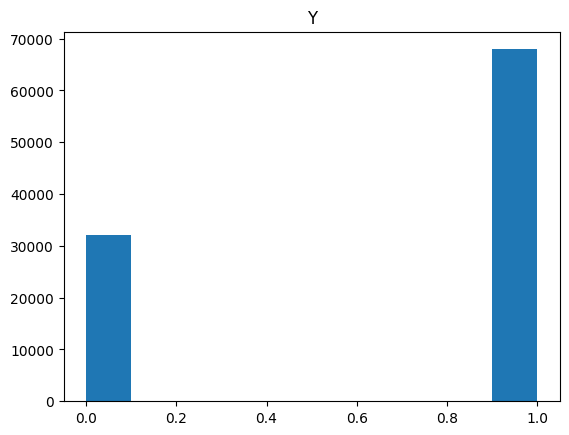

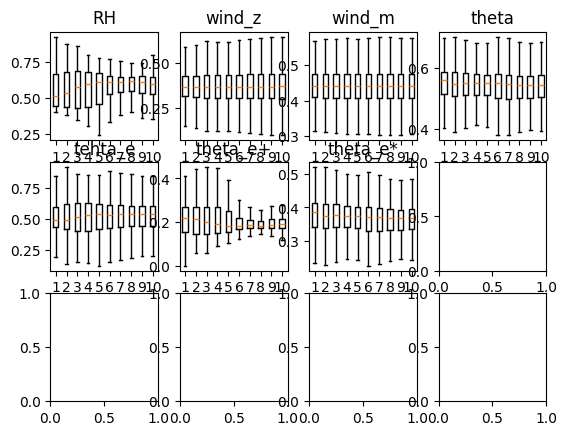

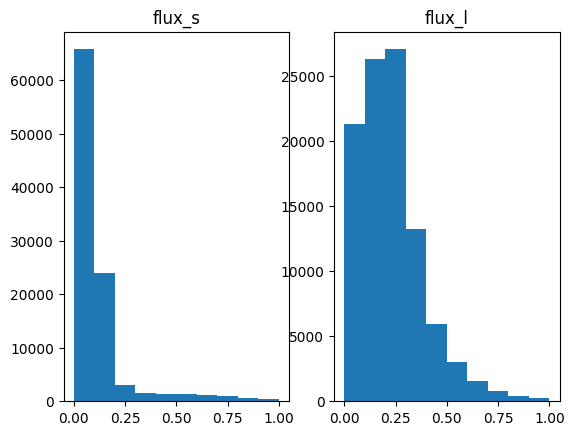

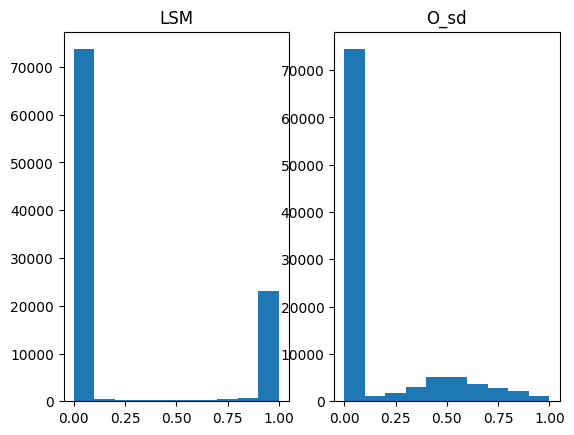

In [3]:

D = VerticalDataset(
    X2d = X2d,
    X3d = X3d,
    Xstatic = Xstatic,
    y=Y,
    standardize=True,
    standardize_with_NF=False,
)

plot_data(problem_info,D)

# plot_marginals(problem_info, D)

In [4]:
def build_log_prior(tau=None) -> callable:

    def log_prior(model):
        log_prob = 0.0

        # if hasattr(model, "smoother"):
        #     smoother_input_scale_prior = tfd.LogNormal(0.0,1.0)
        #     smoother_mean_prior = tfd.Uniform(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels))
        #     log_prob += jnp.sum(smoother_mean_prior.log_prob(model.smoother.smoother_mean))
        #     log_prob += jnp.sum(smoother_input_scale_prior.log_prob(model.smoother.smoother_input_scale))

        lengthscales = jnp.vstack([k.lengthscale for k in model.base_kernels])
        variances = model.interaction_variances
       
        #variance_prior = tfd.Gamma(1.0,0.2)
        #log_prob += jnp.sum(variance_prior.log_prob(variances))

        d = lengthscales.size
        # #l_prior = tfd.LogNormal(jnp.sqrt(2.0) + jnp.log(d)/2.0,jnp.sqrt(1.0))
        # #l_prior = tfd.Gamma(3.0*d,6.0)
        #l_prior = tfd.Gamma(3.0,6.0)
        #log_prob += jnp.sum(l_prior.log_prob(lengthscales))
        l_prior = tfd.HalfCauchy(0.0,tau)
        log_prob += jnp.sum(l_prior.log_prob((1.0 / lengthscales**2)))
            
        #noise_prior = tfd.LogNormal(0.0,10)
        #log_prob += noise_prior.log_prob(model.likelihood.obs_stddev)

        return log_prob
    
    return log_prior



def init_smoother():
    smoother_input_scale_bijector = tfb.Softplus(low=jnp.array(0.1, dtype=jnp.float64))
    smoother_mean_bijector =  tfb.SoftClip(low=jnp.min(pressure_levels), high=jnp.max(pressure_levels))
    smoother = VerticalSmoother(
        jnp.array([[0.0]*num_3d_variables]), 
        jnp.array([[1.0]*num_3d_variables]), 
        Z_levels=pressure_levels
        ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector,smoother_mean=smoother_mean_bijector)
    return smoother


def init_kernels(data, linear=False):
    lengthscale_bij = tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e2, dtype=jnp.float64))
    kernels = []
    if linear:
        kernel = gpx.kernels.Linear(active_dims=[i for i in range(len(names_short))])
        kernels.append(kernel)
    else:
        lsm_idx = names_short.index("LSM")
        for i, name in enumerate(names_short):
            kernel = gpx.kernels.RBF(lengthscale=jnp.array([1.1]), active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale = lengthscale_bij)
            # if name in ["O_sd"]:
            #     kernel *= SwitchKernelPositive(threshold = jnp.array([problem_info.lsm_threshold]), active_dims=[lsm_idx])
            # elif name in ["T_surface"]:
            #     kernel *= SwitchKernelNegative(threshold = jnp.array([problem_info.lsm_threshold]), active_dims=[lsm_idx])
            kernels.append(kernel)
    return kernels
    
def init_likelihood(data, obs_stddev = jnp.array(1.0, dtype=jnp.float64) ):
    obs_bij=tfb.Softplus(low=jnp.array(1e-3, dtype=jnp.float64))
    return gpx.likelihoods.Gaussian(num_datapoints=data.n, obs_stddev=obs_stddev).replace_bijector(obs_stddev=obs_bij)




In [5]:
# # fit with small data
# # prep fancy kernel for model
# # first fit with small data to get init for SVGP
# num_data_for_init=200
# D_small = D.get_subset(num_data_for_init, space_filling=False,use_output=True)

# plot_data(problem_info, D_small)
# starting_var = jnp.var(D_small.y)
# posterior = ConjugatePrecipGP(
#     base_kernels=init_kernels(D_small), 
#     likelihood=init_likelihood(D_small, obs_stddev = jnp.array(1.0, dtype=jnp.float64) ),
#     smoother=init_smoother(),
#     max_interaction_depth=2,
#     interaction_variances=jnp.array([starting_var/3.0]*3, dtype=jnp.float64),
#     jitter=jnp.array(1e-5, dtype=jnp.float64),
#     measure=None,
#     second_order_empirical=False,
#     )
# plt.figure()
# # opt_posterior, history = gpx.fit_scipy(
# #         model=posterior,
# #         objective=jax.jit(posterior.loss_fn(negative=True, log_prior=None, use_loocv=True)),#build_log_prior(tau=1.0))),
# #         train_data=D_small,
# #         safe=False,
# #     )

# opt_posterior, history = gpx.fit(
#         model=posterior,
#         objective=jax.jit(posterior.loss_fn(negative=True,abstractmethod
#         train_data=D_small,
#         optim=ox.adam(1e-1),
#         num_iters=200,
#         safe=False,If I book out the whole
# plot_interactions(problem_info, opt_posterior, D_small, k=5, use_range=False)


  0%|          | 0/500 [00:00<?, ?it/s]

Saturated Equivalent Potential Temperature (theta_e*) and Potential Temperature (theta) have correlation 0.8463767355289011
Stdev of sub-gridscale orography and Land-sea Mask have correlation 0.9079709678439873
interaction vars [4.85290561e-04 1.24228683e+00 1.74581842e+00]


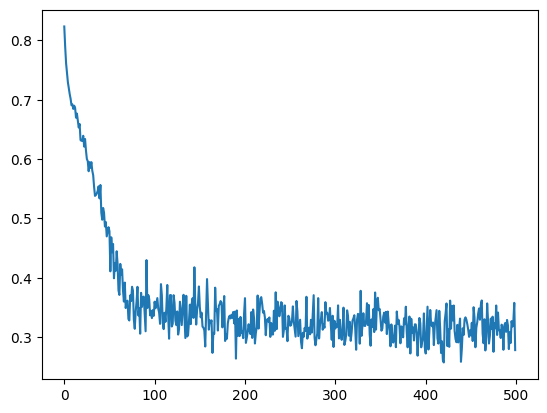

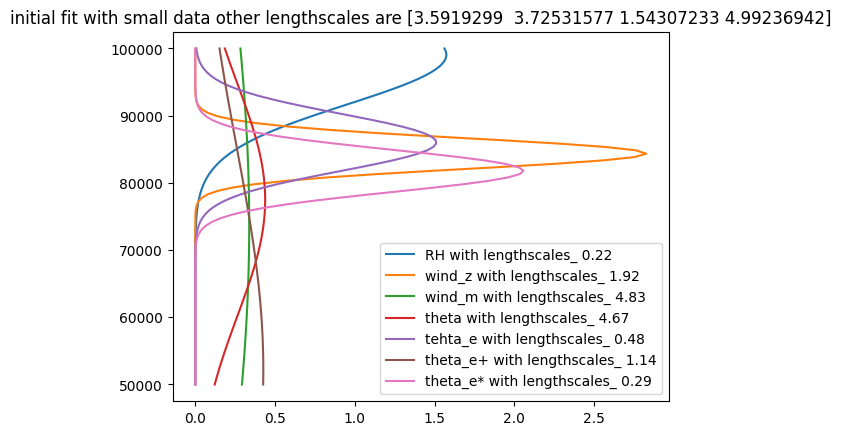

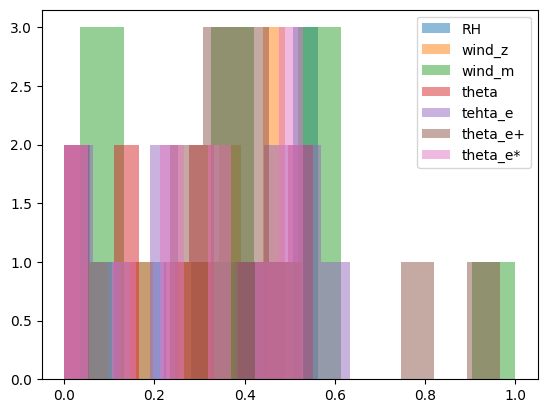

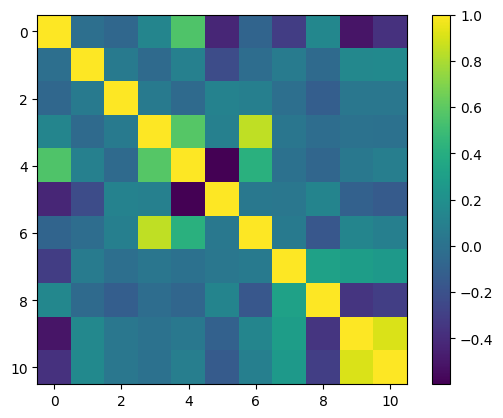

<Figure size 640x480 with 0 Axes>

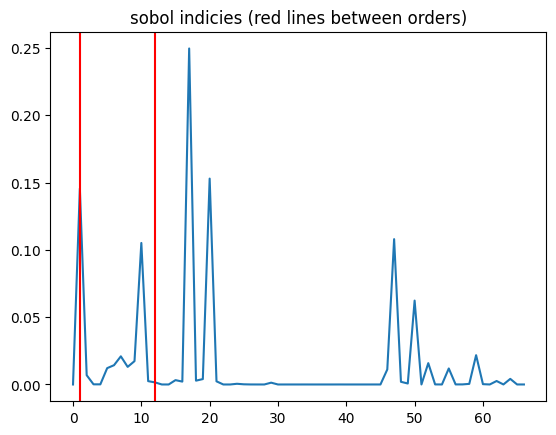

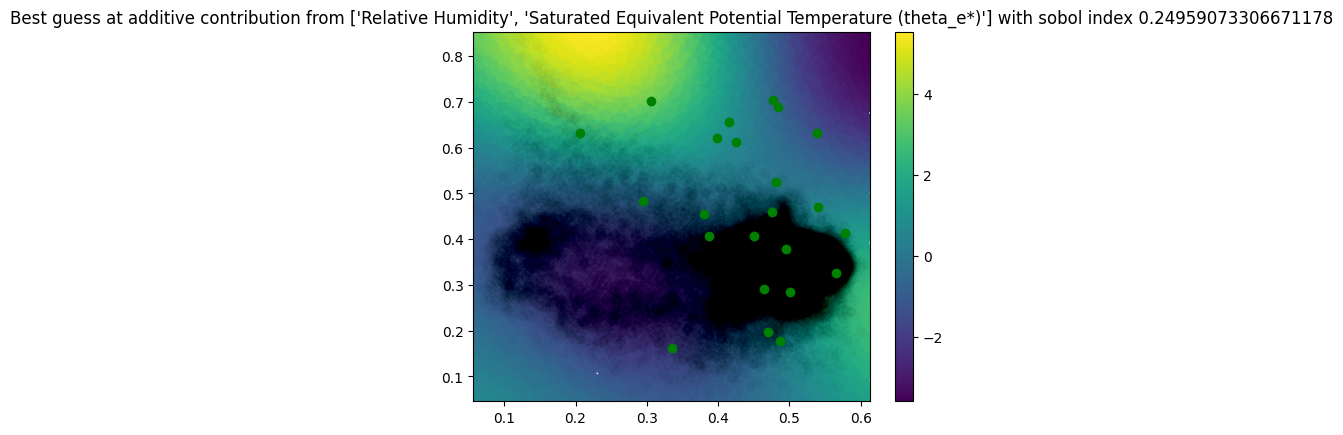

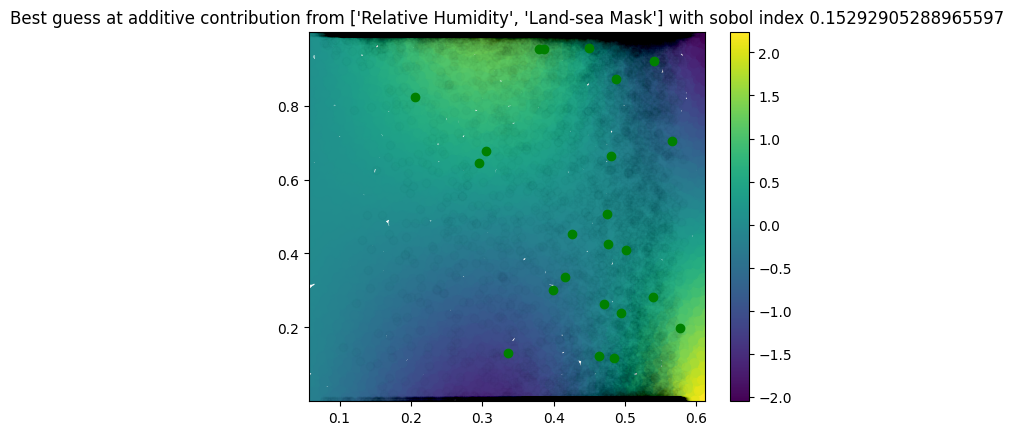

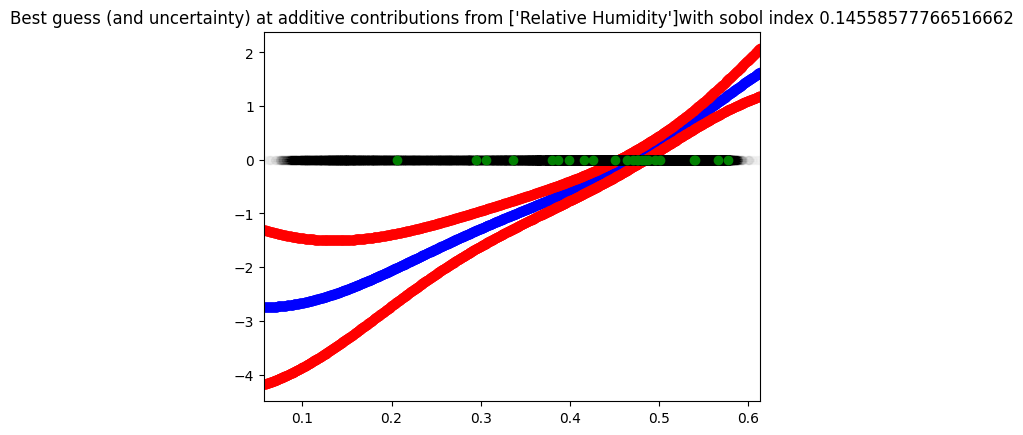

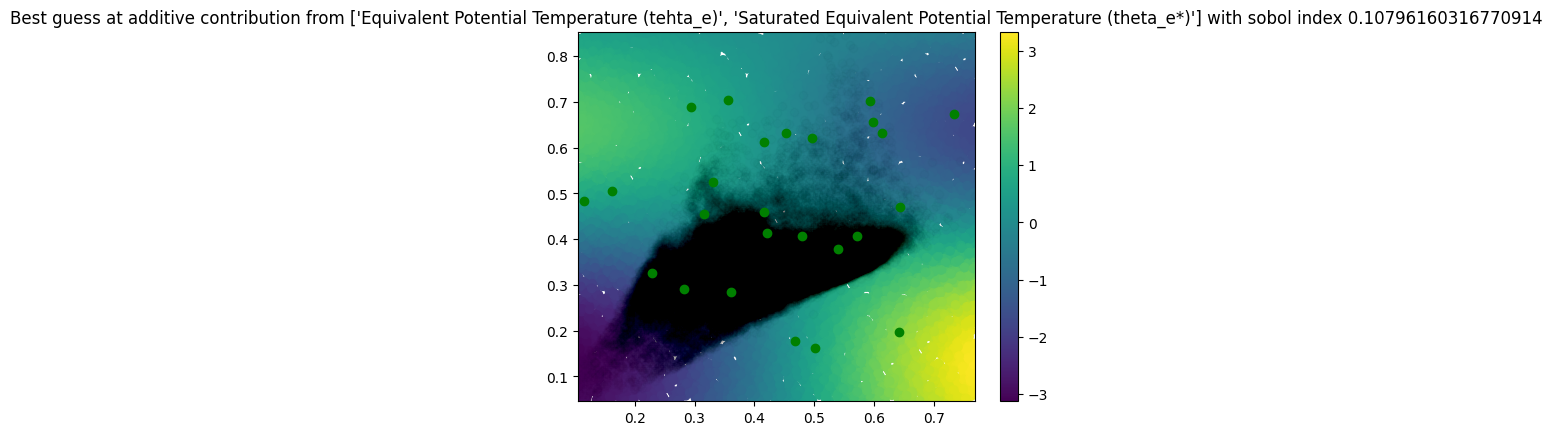

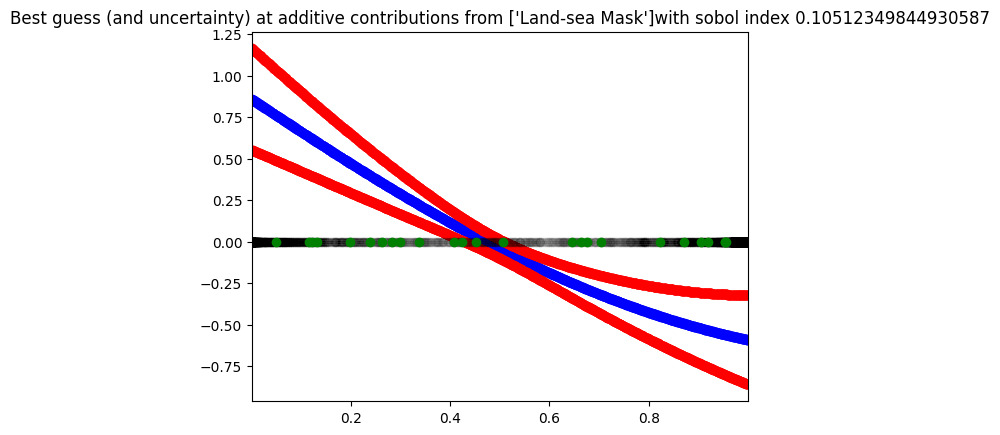

In [6]:

likelihood = gpx.likelihoods.LogitBernoulli(num_datapoints=D.n)
assert jnp.min(D.y) >= 0

num_inducing=25


# smoothed = opt_posterior.smoother.smooth_data(D_small)[0]
#
# sampler = qmc.Halton(d=problem_info.num_variables)
#inducing_inputs  = sampler.random(n=num_inducing) * (jnp.max(smoothed, axis=0) - jnp.min(smoothed, axis=0)) + jnp.min(smoothed, axis=0)
#inducing_inputs = jr.uniform(key, (num_inducing, D_small.dim), minval=jnp.array(1.0, dtype=jnp.float64), maxval=jnp.array(1.0, dtype=jnp.float64))
# variational_mean = opt_posterior.predict(inducing_inputs, D_small).mean()[:,None]
# if isinstance(likelihood, (gpx.likelihoods.Exponential, gpx.likelihoods.Gamma)):
#     variational_mean = jnp.log(jnp.maximum(variational_mean,1e-5))
   
smoother = init_smoother()


inducing_inputs = qmc.Halton(d=problem_info.num_3d_variables+ problem_info.num_2d_variables+problem_info.num_static_variables, seed=1234).random(n=num_inducing)

# look at spread after smoothing to get init range
samples = qmc.Halton(d=problem_info.num_3d_variables*problem_info.pressure_levels.shape[1], seed=1234).random(n=10_000)
smoothed_samples = smoother.smooth_X(samples.reshape(10_000,problem_info.num_3d_variables, -1 ))
inducing_inputs_3d = inducing_inputs[:,:problem_info.num_3d_variables] * (jnp.max(smoothed_samples,0) - jnp.min(smoothed_samples,0)) + jnp.min(smoothed_samples,0)
inducing_inputs = jnp.hstack([inducing_inputs_3d, inducing_inputs[:,problem_info.num_3d_variables:]])

variational_mean  = jnp.zeros((num_inducing,1), dtype=jnp.float64)
max_depth = 2
variational_posterior = VariationalPrecipGP(
    base_kernels=init_kernels(D), 
    likelihood=likelihood,
    smoother=init_smoother(),
    max_interaction_depth=max_depth,
    interaction_variances=jnp.array([1.0/(max_depth+1)]*(max_depth+1), dtype=jnp.float64),
    jitter=jnp.array(1e-6, dtype=jnp.float64),
    measure = "empirical",
    second_order_empirical=False,
    inducing_inputs=inducing_inputs,
    parameterisation="standard",
    )



plt.figure()

#variational_posterior = variational_posterior.replace_trainable(inducing_inputs_3d=False, inducing_inputs_2d=False, inducing_inputs_static=False)
variational_posterior = variational_posterior.replace_bijector(
    inducing_inputs = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    variational_mean = tfb.SoftClip(low=jnp.array(-1e5, dtype=jnp.float64),high=jnp.array(1e3, dtype=jnp.float64)),
    variational_root_covariance = tfb.Chain([tfb.FillTriangular(), tfb.SoftClip(low=jnp.array(-1e3, dtype=jnp.float64),high=jnp.array(1e3, dtype=jnp.float64))]),
    )




model_optim = ox.adam(1e-1)
variational_optim = ox.adam(1e-2)
optim_1_pytree = variational_posterior.replace(
    base_kernels = model_optim, 
    likelihood = model_optim,
    interaction_variances = model_optim,
    smoother = model_optim,
    variational_mean = variational_optim,
    variational_root_covariance = variational_optim, 
    inducing_inputs= variational_optim,
    )
optim_1 = optim_builder(optim_1_pytree)



#optim_1 = ox.adamw(1e-2)
opt_variational_posterior, history = gpx.fit(
        model=variational_posterior,
        objective=jax.jit(variational_posterior.loss_fn(negative=True, log_prior=None)), #todo rejit
        train_data=D,
        optim=optim_1,
        num_iters=500,
        batch_size=512,
        safe=False,
        key=key,
    )





# prep for infernece 

plt.plot(history)
#plt.ylim(jnp.min(history), jnp.quantile(history,0.99))
plot_params(problem_info, opt_variational_posterior,D, title="initial fit with small data", print_corr=True)
try:
    print(f"noise is {opt_variational_posterior.likelihood.obs_stddev}")
except:
    try:
        print(f"scalee is {opt_variational_posterior.likelihood.scale1}")
    except:
        pass
    pass
print(f"interaction vars {opt_variational_posterior.interaction_variances}")
plot_interactions(problem_info, opt_variational_posterior, D, k=5, use_range=False)



removed O_sd
with a loss in performance of -0.0007725113481929502
removed theta
with a loss in performance of 0.00024853654427153815
removed wind_m
with a loss in performance of -5.323977344334763e-05
removed flux_l
with a loss in performance of 0.0072039456083954345
removed wind_z
with a loss in performance of 0.008881063049731075
removed flux_s
with a loss in performance of 0.033145724145371425


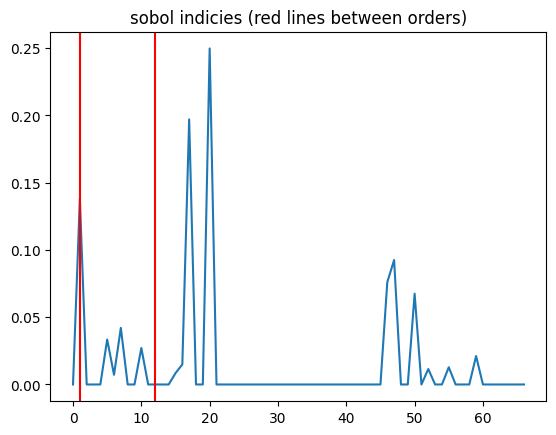

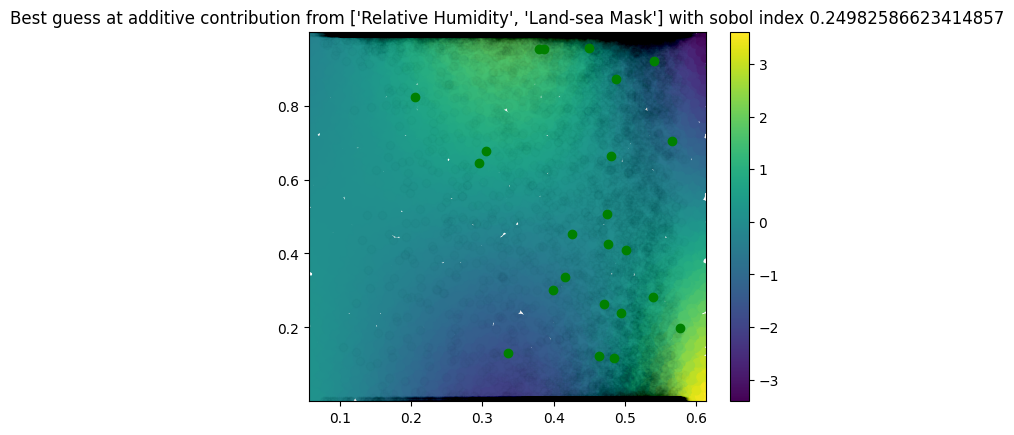

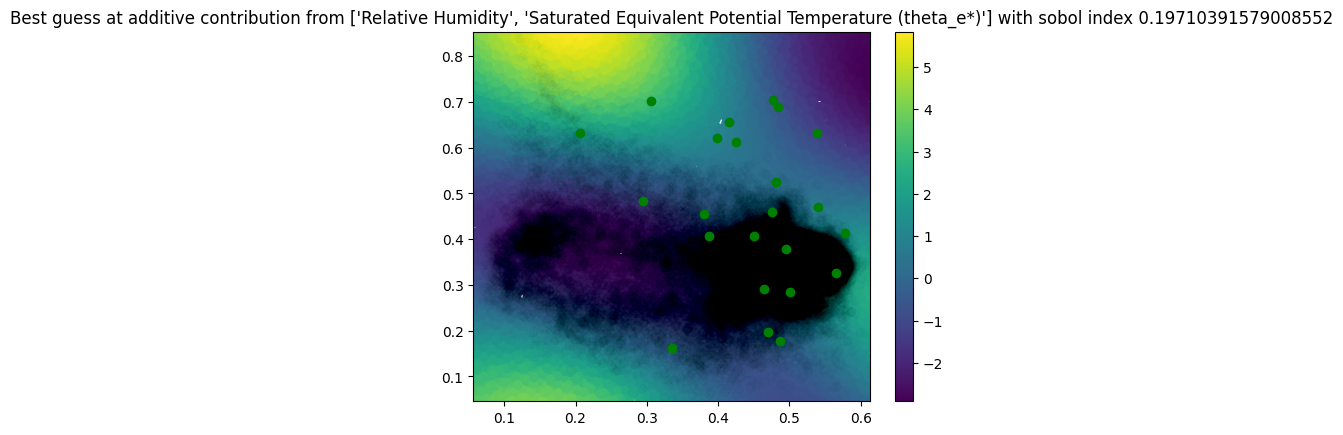

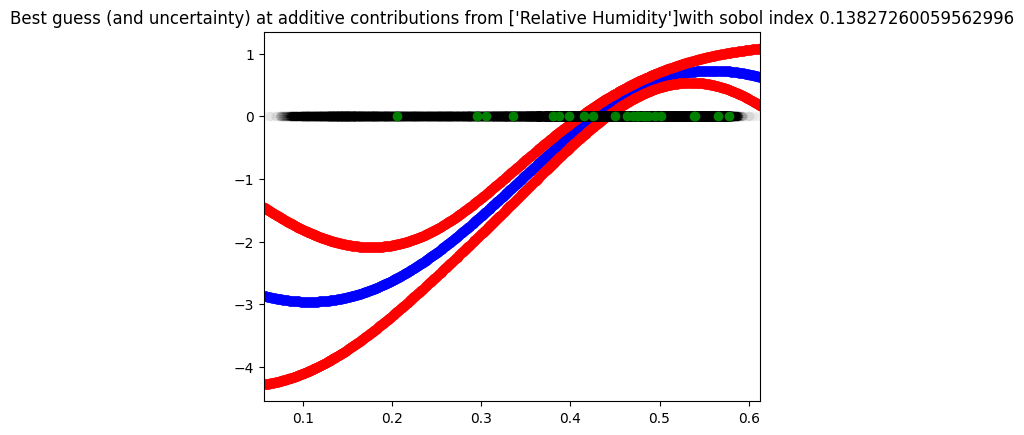

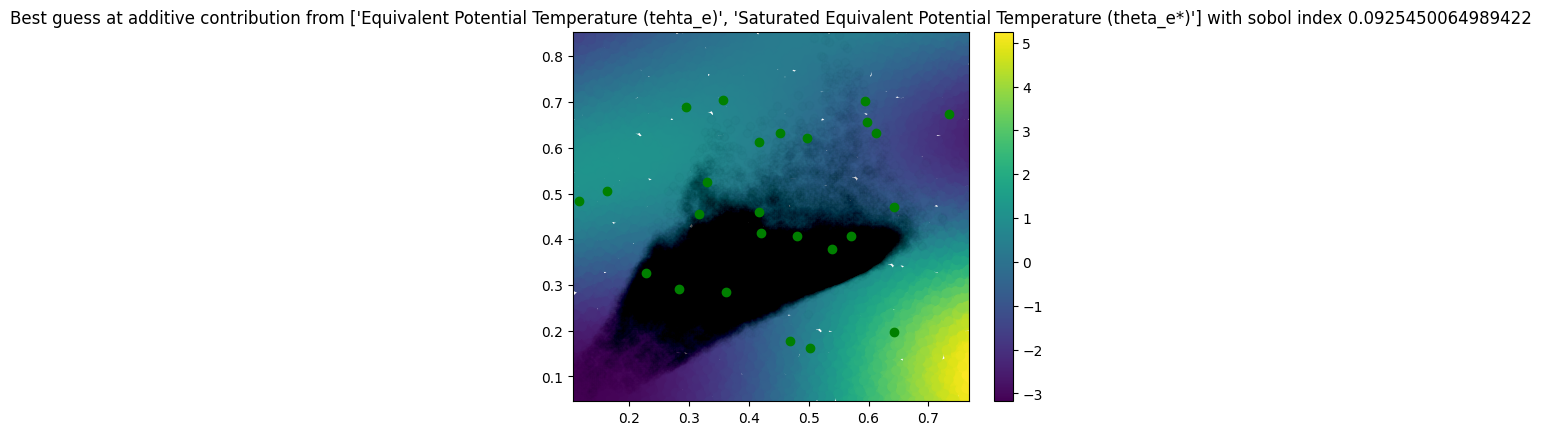

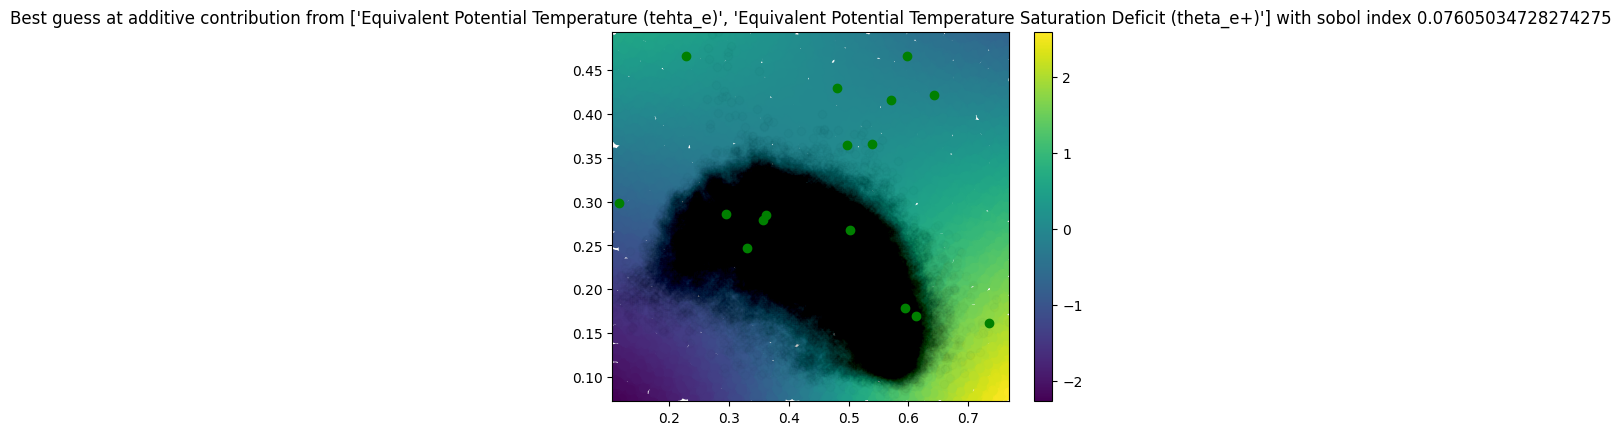

In [7]:
thinned_model = thin_model(problem_info, D.get_subset(1_000), opt_variational_posterior, 5)
plot_interactions(problem_info, thinned_model, D, k=5, use_range=False)